## 1. Introduction

This Web Scrape project is using Verizon Wireless website as the base url (https://www.verizonwireless.com/smartphones/), extracting smart phone information including brand, models, price, reviews, then use the data for analysis, visualization and interpretation.

## 2. Scraping Script
The scraping script is written in python, using selenium and Chrome webdriver, the code is stored in https://github.com/jtlqh/shiny. Here is a short clip of the script running in real-time. Collected data is stored in mySQL database.


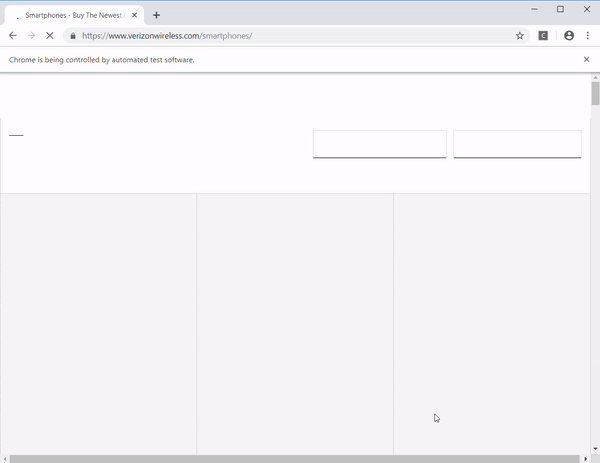

In [2]:
from IPython.display import Image
Image(filename='verizonwireless scrapping.png') 

## 3. Data Processing
### 3.1 Cleaning
- read product (phone) and review data from mySQL database using peewee model
- remove 'id' column, drop duplicate entries due if script was run multiple times
- There are 42 Smart Phone models
- There are 30362 reviews
- Display of snapshots on smart phone data and review data

In [1]:
from db import *
import pandas as pd
review = Review()
product = Product()
review_summary = Review_summary()


review_records = review.select()
product_records = product.select()
summary_records = review_summary.select()



In [2]:

review_df = pd.DataFrame(list(review_records.dicts())).drop(columns='id')
product_df = pd.DataFrame(list(product_records.dicts())).drop(columns='id').drop_duplicates()
summary_df =pd.DataFrame(list(summary_records.dicts())).drop(columns='id')
print('size of review dataframe: ',review_df.shape)
print(review_df.info())
print('size product dataframe: ',product_df.shape)
print(product_df.info())
print('size review summary dataframe: ',summary_df.shape)
print(summary_df.info())


size of review dataframe:  (30501, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30501 entries, 0 to 30500
Data columns (total 10 columns):
date_published    30501 non-null datetime64[ns]
helpful           30501 non-null int64
rating            30501 non-null int64
recommending      30501 non-null object
skuId             30501 non-null object
store             30501 non-null object
text              30501 non-null object
title             30501 non-null object
unhelpful         30501 non-null int64
username          30501 non-null object
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 2.3+ MB
None
size product dataframe:  (1133, 9)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1133 entries, 0 to 1132
Data columns (total 9 columns):
brand           1133 non-null object
color           1133 non-null object
price           1133 non-null float64
product_name    1133 non-null object
skuId           1133 non-null object
spec_name       1133 non-null object
spec_valu

Trim phone model name to 20 characters and merge product_df to summary_df


### 3.2 Data Analysis


#### Brand, Models and Prices
Apple, Samsung have the most models, next are Google, LG and Motorola.
Apple and Samsung phones also seemed to have bigger price range, from \\$200 to over \\$1000


In [4]:
pd.set_option('display.max_columns',20)
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (14,6)


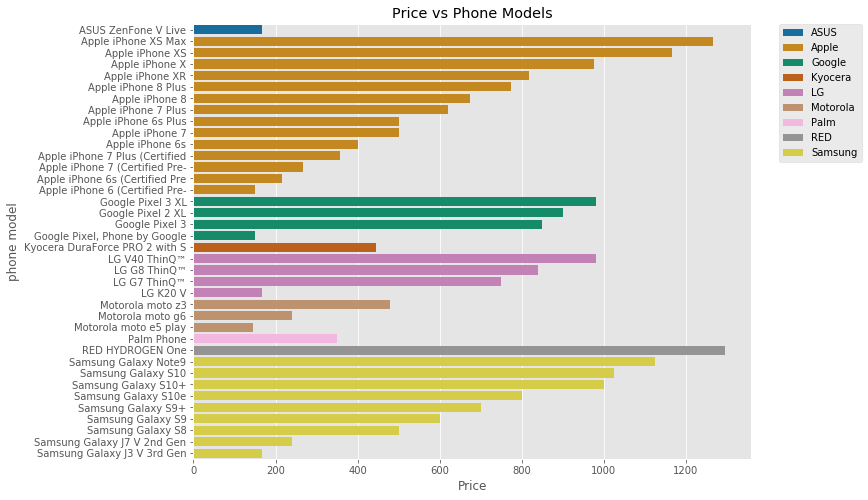

In [5]:
import seaborn as sns
product_df['product_name']=product_df['product_name'].apply(lambda x: x[:30].strip())
new_product = product_df.merge(summary_df, how='right', on='skuId', suffixes=('_x', ''))
avg_price= pd.DataFrame(product_df.groupby(['brand','product_name'])['price'].mean() )
avg_price.columns = ['price']
avg_price = avg_price.reset_index().sort_values(by=['brand','price'], ascending=[True,False])

plt.figure(figsize=(10,8))
sns.barplot(data=avg_price, y='product_name',x='price',hue='brand', dodge=False, palette="colorblind")
plt.ylabel('phone model')
plt.xlabel('Price')
plt.title("Price vs Phone Models")
plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.)

Text(0.5, 1.0, 'Number of Models vs Brand')

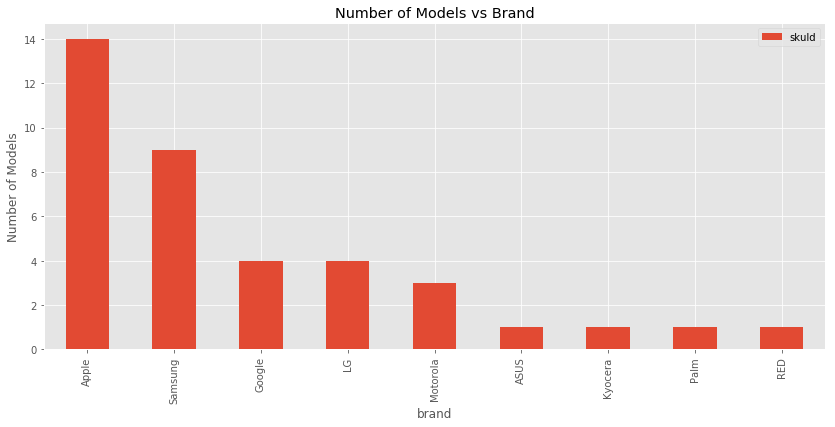

In [6]:
models = product_df[['brand','skuId']].drop_duplicates().pivot_table(values='skuId',index='brand', aggfunc='count').sort_values(by='skuId',ascending=False)
models.plot.bar()
plt.ylabel('Number of Models')
plt.title("Number of Models vs Brand")

Text(0.5, 1.0, 'Phone Price vs Brand')

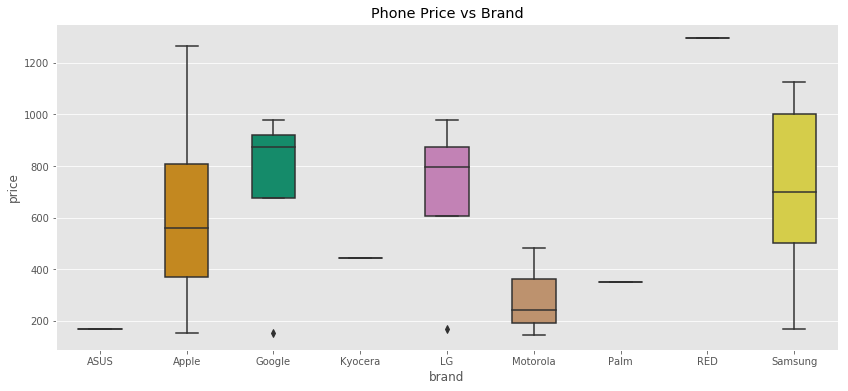

In [7]:
import seaborn as sns

price_brand= new_product.pivot_table(values='price', index=['brand','product_name'])
price_brand.index = price_brand.index.droplevel(level=1)
price_brand = price_brand.reset_index()
sns.boxplot(y='price',x='brand',data=price_brand, width=0.5, palette="colorblind")
plt.title("Phone Price vs Brand")



#### Rreviews
- Popularity:
Apple phones are the most popular phones, with the largest number of users participation in the reviews.
- Buy Recommendation:
LG phones got the largest "Buy" votes, Samsung phones have the the widest range of "Buy" votes among varies models 
- Ratings
Apple phones have the larger range across all the 5 rating group in regards to raw count, Samsung phones have a larger number of 1 ratings. But in the percentage boxplot, LG phones have the highest percentage ofd 5 ratings in its own group, and Motorola phones have the highest percentage of 1-rating.



In [8]:
product=new_product[['brand','skuId','product_name','design','display','feature','storage', 'batterylife']].drop_duplicates()
df = review_df.merge(product, how='left', on='skuId',suffixes=('_x', ''))

df =df.merge(
    avg_price.reset_index().drop(columns=['brand']), how='left', on='product_name').groupby(
    'skuId').filter(lambda x: x.shape[0]>10)   #remove models with review less than 10
df['recommending']=df.recommending.apply(lambda x: 1 if x=='True' else 0)


Text(0.5, 1.0, 'Popularity (Log of Reviews) vs Brand')

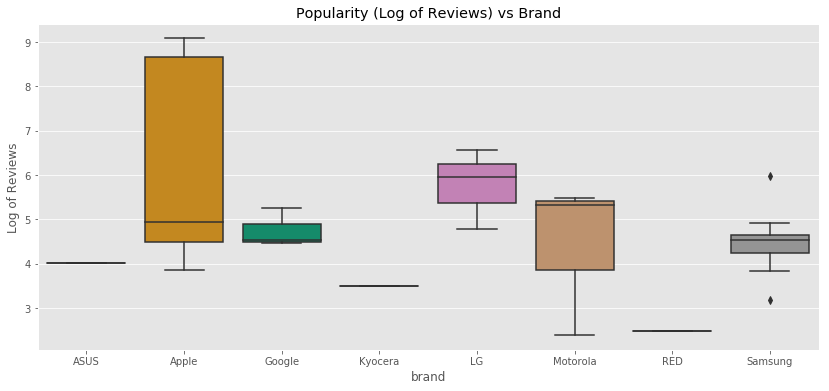

In [9]:
import numpy as np
popular = df.groupby('brand')['product_name'].value_counts().apply(lambda x: np.log(x))
popular_df = pd.DataFrame(popular)
popular_df.index = popular_df.index.droplevel(1)
popular_df = popular_df.reset_index()
sns.boxplot(y='product_name', x='brand',data=popular_df,palette="colorblind")
plt.ylabel("Log of Reviews")
plt.title("Popularity (Log of Reviews) vs Brand")

Text(0.5, 1.0, 'Log of Review Numbers vs Phone Models')

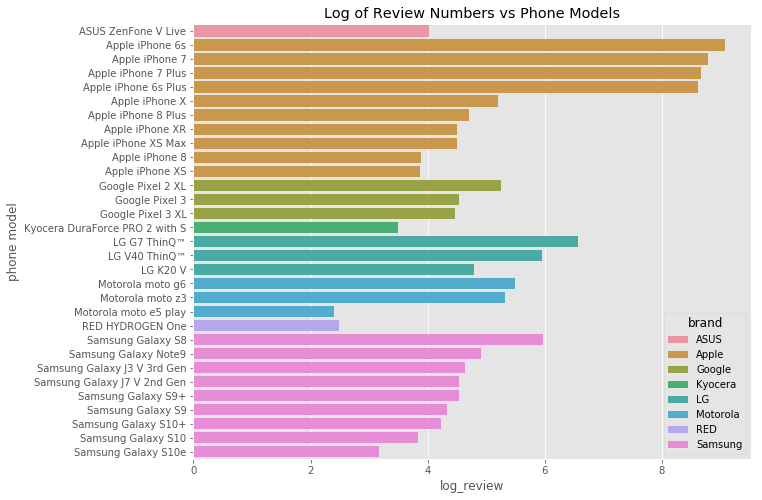

In [10]:
popular_df = pd.DataFrame(popular)
popular_df.columns=['log_review']
popular_df = popular_df.reset_index()
plt.figure(figsize=(10,8))

sns.barplot(data=popular_df,y='product_name', x='log_review',hue='brand', dodge=False)
plt.ylabel('phone model')
plt.title('Log of Review Numbers vs Phone Models')

Text(0, 0.5, 'Log of Raw Count')

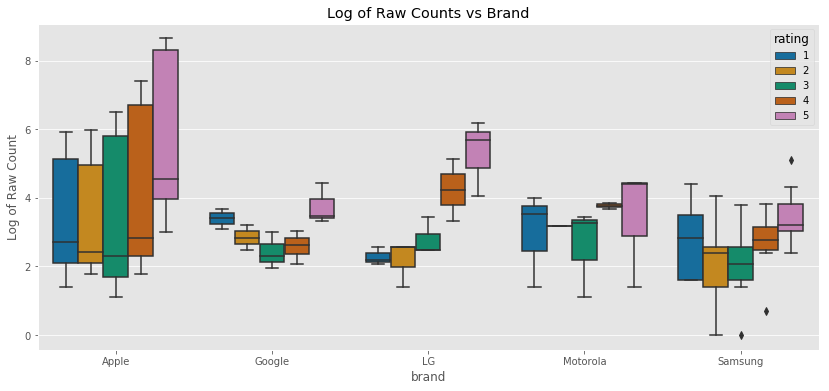

In [11]:


def filter_brand(x):
    keep_list= ['brand','design', 'display', 'feature', 'storage', 'batterylife']
    return (x['brand'] in ['Apple','Google','LG','Motorola', 'Samsung'])

rating_df = pd.DataFrame(df.groupby(['brand','product_name'])['rating'].value_counts())
rating_df.columns=['count']
df1 = rating_df.apply(lambda x: np.log(x))
df1.index=df1.index.droplevel(level=1)
df1 = df1.reset_index()
df1 = df1.loc[df1.apply(filter_brand, axis=1)]
sns.boxplot(x='brand', hue='rating', y='count', data=df1,palette="colorblind")
plt.title('Log of Raw Counts vs Brand')
plt.ylabel('Log of Raw Count')


Text(0.5, 1.0, 'Reviews were Voted Helpful and Unhelpful Since Model Release')

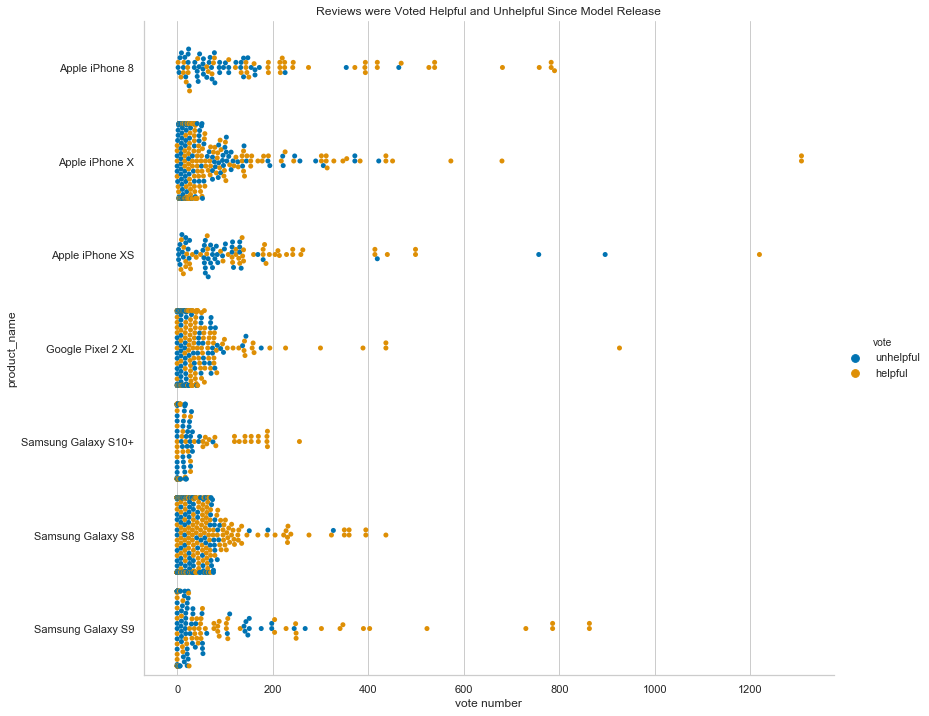

In [50]:
models = ['Samsung Galaxy S10+', 'Google Pixel 2 XL', 'Samsung Galaxy S9', 'Samsung Galaxy S8', 'Apple iPhone X', 'Apple iPhone XS', 'Apple iPhone 8']
helpfulness = df.loc[df['product_name'].apply(lambda x: x in models)][['product_name', 'helpful', 'unhelpful']]
helpfulness = helpfulness.melt(id_vars=['product_name'], var_name='vote', value_name='vote number').sort_values(by=['product_name'])

sns.catplot(kind='swarm', x='vote number', hue='vote', y='product_name', data=helpfulness, height=10, aspect=1.2,palette="colorblind")
#plt.title("Reviews were Voted Helpful and Unhelpful")
plt.title("Reviews were Voted Helpful and Unhelpful Since Model Release")

<function seaborn.categorical.stripplot(x=None, y=None, hue=None, data=None, order=None, hue_order=None, jitter=True, dodge=False, orient=None, color=None, palette=None, size=5, edgecolor='gray', linewidth=0, ax=None, **kwargs)>

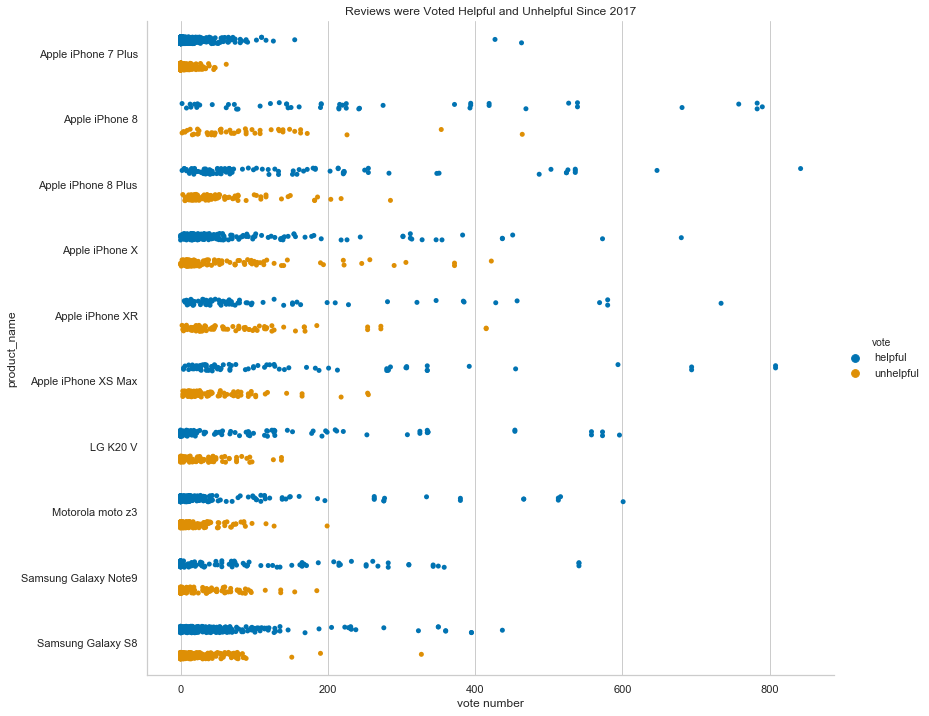

In [45]:

helpfulness = df.loc[df['date_published']>'2017'][['product_name', 'helpful', 'unhelpful']]
models=helpfulness.groupby('product_name').agg({'helpful':'sum','unhelpful':'sum'}).sort_values(by=['helpful','unhelpful'], ascending=False)[:10].index

helpfulness=helpfulness.loc[helpfulness.apply(lambda x: x['product_name'] in models, axis=1)]


helpfulness = helpfulness.melt(id_vars=['product_name'], var_name='vote', value_name='vote number').sort_values(by=['product_name'])
helpfulness=helpfulness.loc[helpfulness['vote number']<1000]
sns.set(style="whitegrid")
sns.catplot(kind='strip', x='vote number', hue='vote', y='product_name',dodge=True, jitter=True,data=helpfulness, height=10, aspect=1.2, palette="colorblind")
plt.title("Reviews were Voted Helpful and Unhelpful Since 2017")
sns.stripplot


Text(0, 0.5, 'Percent Buy Recommandation (%)')

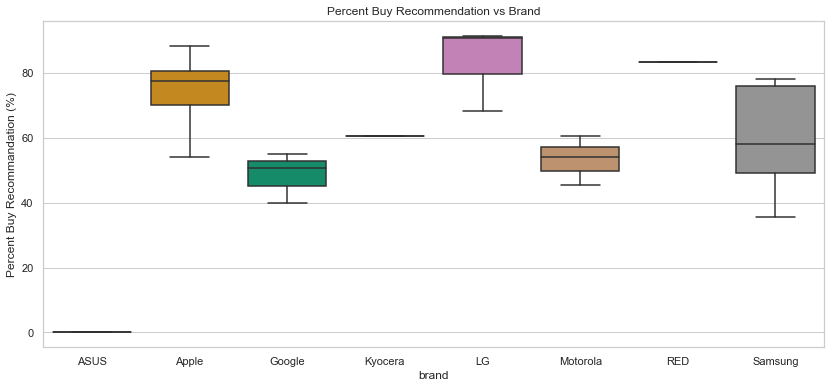

In [48]:
gp = df.groupby(['brand','product_name'])
pct_recommend = gp['recommending'].apply(lambda x: sum(x ==1)/len(x)*100)
pct_recommend.index = pct_recommend.index.droplevel(level=1)
pct_recommend = pct_recommend.reset_index()

sns.boxplot(x='brand',y='recommending', data=pct_recommend, palette="colorblind")
plt.title('Percent Buy Recommendation vs Brand')
plt.ylabel("Percent Buy Recommandation (%)")

Text(0.5, 1.0, 'Percent of rating 1, 2 , 3, 4, 5 on Brand')

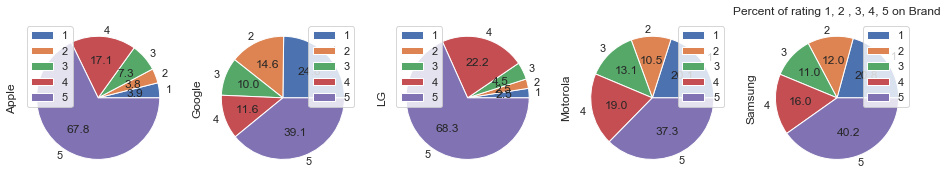

In [47]:
df1=rating_df.copy()
df1.index=df1.index.droplevel(level=1)
df1 = df1.reset_index()
df1 = df1.loc[df1['brand'].apply(lambda x: x in ['Apple', 'Google', 'LG', 'Motorola', 'Samsung'])].groupby(['brand','rating']).sum()

rating=df1.reset_index().set_index(['brand','rating'])['count'].unstack()
plot = rating.T.plot.pie(subplots=True, figsize=(16, 3), autopct='%.1f')
plt.title('Percent of rating 1, 2 , 3, 4, 5 on Brand')


Text(0.5, 1.0, 'Ratings on Design, Display, Feature, Storage and BatteryLife on Phone Brand')

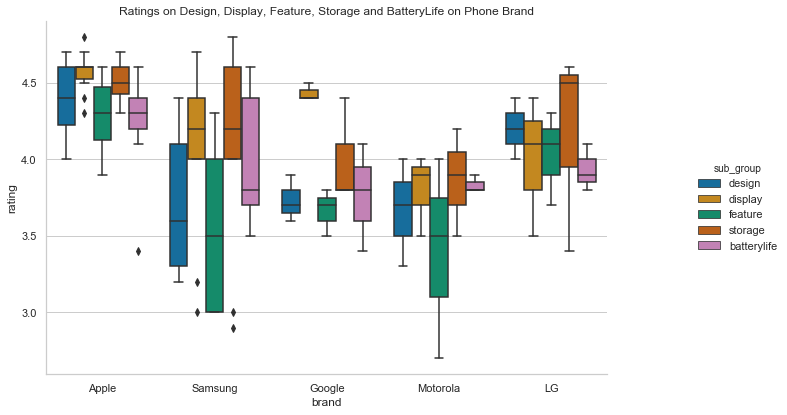

In [51]:
plot_list=['brand','design', 'display', 'feature', 'storage', 'batterylife']
sub_df = df.loc[df.apply(filter_brand, axis=1)][plot_list]
sub_df[plot_list[1:]] = sub_df[plot_list[1:]].apply(pd.to_numeric)
sub_df = sub_df.drop_duplicates()
sub_df = sub_df.melt(id_vars='brand',var_name='sub_group', value_name='rating')
#print(sub_df.head())
g=sns.catplot(data=sub_df, x = 'brand',y='rating', hue='sub_group',  kind='box', palette="colorblind")
g.fig.set_size_inches(12,6)


plt.title("Sub Group Ratings on Phone Brand")

#g = sns.FacetGrid(data = sub_df, row='sub_group')
#g.map(sns.boxplot,  'rating', 'brand')
#g.fig.set_size_inches(8,6)
plt.title("Ratings on Design, Display, Feature, Storage and BatteryLife on Phone Brand")


Text(0, 0.5, 'Buy Recommendation')

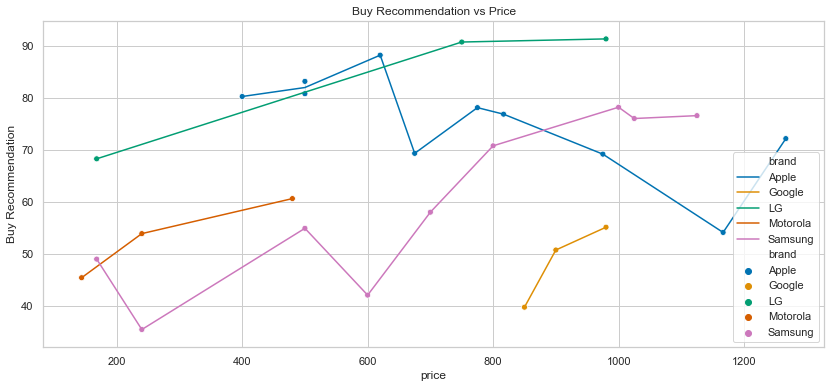

In [53]:
df1 = df[['brand','product_name','price']].drop_duplicates()
df1 = df1.loc[df1.apply(filter_brand, axis=1)]
new_df = df.groupby(['brand','product_name'])['recommending'].apply(lambda x: np.mean(x)*100)
new_df = new_df.reset_index().merge(df1, how='right', on='product_name', suffixes=('', '_y')).drop(columns=['brand_y', 'product_name'])
sns.lineplot(x='price', y='recommending', hue='brand',  data=new_df, palette="colorblind")
sns.scatterplot(x='price', y='recommending', hue='brand',  data=new_df, palette="colorblind")
plt.title('Buy Recommendation vs Price')
plt.ylabel('Buy Recommendation')
#g.fig.set_size_inches(14,6)

In [54]:
import nltk
import re
df1=df.copy()
df1.columns
df1['text'] = df1['title'] + ' ' + df1['text'] 

pd.set_option('max_colwidth',200)
df1['text']=df1['text'].str.lower().apply(lambda x: re.sub('\s+', ' ', x))
#df1['text'].sample(10)

#remove punctuation
df1['text']=df1['text'].apply(lambda x: re.sub('[^\w\s]','',x))

In [55]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
#stop.extend(['iphone', '6s','plus'])
#stop.extend(['im', 'ive', 'iphone', 'x','xs', 'max', 'phone', 'due','still','phones'])
#print(stop)
df1['text']=df1['text'].apply(lambda x: " ".join(word for word in x.split() if word not in stop))

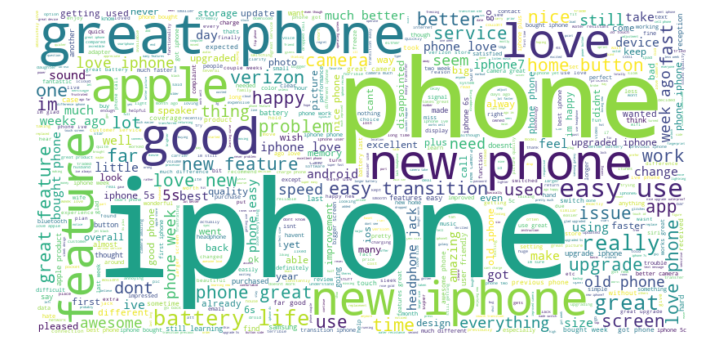

In [58]:
from wordcloud import WordCloud
wc = WordCloud(background_color="white", max_words=20000, width=800, height=400)
# generate word cloud

mask = df1['product_name']=='Apple iPhone 7'
iphone_7 = df1[mask]
wc.generate(' '.join(iphone_7['text']))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

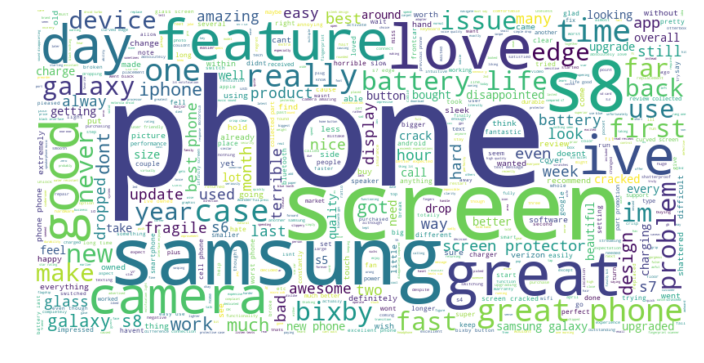

In [59]:
#wc = WordCloud(background_color="white", max_words=20000, width=800, height=400)# generate word cloud
mask = df1['product_name']=='Samsung Galaxy S8'
samsung_S8 = df1[mask]
wc.generate(' '.join(samsung_S8['text']))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()